In [1]:
%load_ext autoreload
%autoreload 2

import wave_networks.test as test

test.hello_world()

Hello World


In [2]:
import dotenv
import wandb
import os

dotenv.load_dotenv(os.path.join('/homes/55/bwilop/wsg/private/', 'vscode-ssh.env'))
api_key = os.getenv('WANDB_API_KEY')
wandb.login(key=api_key)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: benwilop (benwilop-rwth-aachen-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /homes/55/bwilop/.netrc


True

In [3]:
# https://soundata.readthedocs.io/en/latest/source/tutorial.html
import soundata
urbansound8k = soundata.initialize('urbansound8k', data_home='/homes/55/bwilop/gdl/ablation_study_wavelet_networks/data')
# urbansound8k.download()  
# urbansound8k.validate() 

In [4]:
from wave_networks.prepare_data import *

path = "/homes/55/bwilop/gdl/ablation_study_wavelet_networks/calculated_data/preprocessed_data.pkl"
dataset_audio_timeseries = compute_dataset_audio_timeseries(path, urbansound8k)

/homes/55/bwilop/gdl/wavelet_networks/wavelet_networks/wavelet_networks_venv/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
print(dataset_audio_timeseries.train_data.shape)
print(dataset_audio_timeseries.validation_data.shape)
print(dataset_audio_timeseries.test_data.shape)

torch.Size([6273, 90000])
torch.Size([806, 90000])
torch.Size([1653, 90000])


In [ ]:
from wave_networks.training import train_model
from wave_networks.architecture_definitions import *

# model_name = "StandardConvolutionalNetwork"
# model_name = "2D_ConvolutionalNet"
# model_name = "minimal_WaveletNetwork"
model_name = "WaveletNetwork"

if model_name == "StandardConvolutionalNetwork":
    model = StandardConvolutionalNetwork()
elif model_name == "2D_ConvolutionalNet":
    model = build_2D_ConvolutionalNet()
elif model_name == "WaveletNetwork":
    model = build_WaveletNetwork()
elif model_name == "minimal_WaveletNetwork":
    model = build_minimal_WaveletNetwork()
folder = "/homes/55/bwilop/gdl/ablation_study_wavelet_networks/trained_models"
train_parameters = {
    'batch_size': 64,
    'learning_rate': 1e-3,
    'weight_decay': 1e-4,
    'max_epochs': 100,
    'early_stopping_patience': 3,
}
model = train_model(model, model_name, dataset_audio_timeseries, train_parameters, folder)

------------- EPOCH {epoch} -------------
0
10
20


KeyboardInterrupt: 

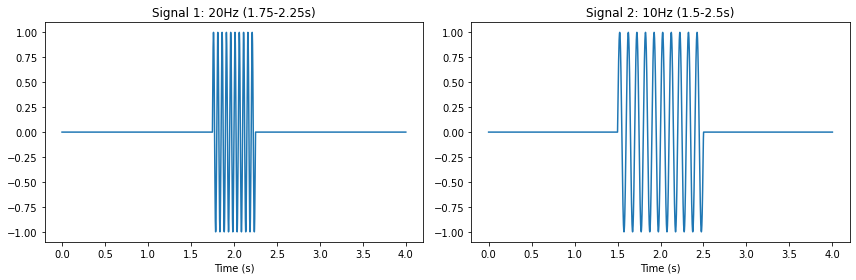

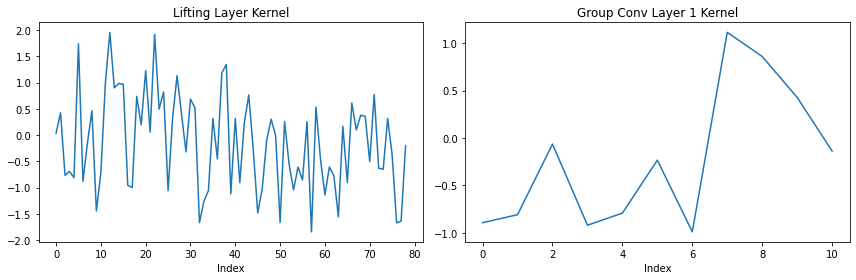

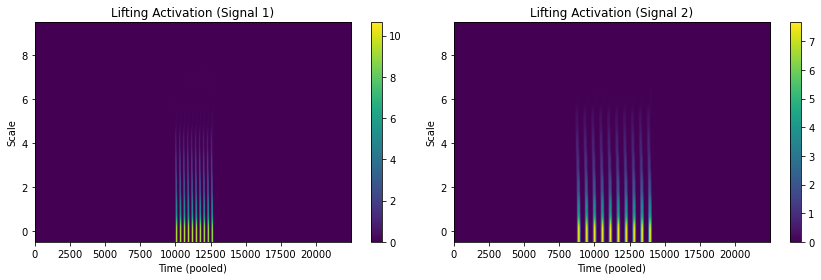

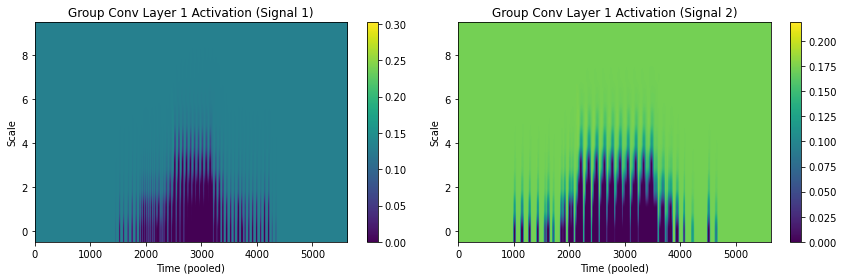

In [ ]:
import torch as t
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math

# ----- Signal Generation -----
def generate_signals(fs=22500, duration=4.0):
    total_samples = int(fs * duration)
    t_axis = np.linspace(0, duration, total_samples, endpoint=False)
    sig1 = np.zeros(total_samples, dtype=np.float32)
    sig2 = np.zeros(total_samples, dtype=np.float32)
    # Signal 1: 20Hz from 1.75s to 2.25s.
    idx1 = np.logical_and(t_axis >= 1.75, t_axis < 2.25)
    sig1[idx1] = np.sin(2 * np.pi * 20 * t_axis[idx1])
    # Signal 2: 10Hz from 1.5s to 2.5s.
    idx2 = np.logical_and(t_axis >= 1.5, t_axis < 2.5)
    sig2[idx2] = np.sin(2 * np.pi * 10 * t_axis[idx2])
    # Return as [B, 1, T]
    return t.tensor(sig1).unsqueeze(0).unsqueeze(0), t.tensor(sig2).unsqueeze(0).unsqueeze(0), t_axis

# ----- Intermediate Activations -----
def get_activations(model: t.nn.Module, x: t.Tensor):
    # Lifting branch.
    x_lift = model.G_lifting_layer(x)         # [B, C, T, S]
    x_lift = model.pool(x_lift)                 # [B, C, T/4, S]
    x_lift = model.bn_G_lifting_layer(x_lift)
    act_lift = F.relu(x_lift)
    # Group conv branch (first layer).
    conv1 = model.G_convolutional_layers[0]
    bn1   = model.bn_G_convolutional_layers[0]
    x_group = conv1(act_lift)
    x_group = model.pool(x_group)
    x_group = bn1(x_group)
    act_group = F.relu(x_group)
    return act_lift, act_group

# ----- Visualization -----
def visualize(model: t.nn.Module):
    # Generate signals.
    sig1, sig2, t_axis = generate_signals()
    
    # Plot input signals.
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(t_axis, sig1.squeeze().numpy())
    axs[0].set_title("Signal 1: 20Hz (1.75-2.25s)")
    axs[0].set_xlabel("Time (s)")
    axs[1].plot(t_axis, sig2.squeeze().numpy())
    axs[1].set_title("Signal 2: 10Hz (1.5-2.5s)")
    axs[1].set_xlabel("Time (s)")
    plt.tight_layout()
    plt.show()
    
    # Plot kernels.
    lifting_kernel = model.G_lifting_layer.kernel.detach().cpu().numpy().squeeze()  # [kernel_size]
    group_conv1_kernel = model.G_convolutional_layers[0].kernel.detach().cpu().numpy().squeeze()  # [kernel_size]
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(lifting_kernel)
    axs[0].set_title("Lifting Layer Kernel")
    axs[0].set_xlabel("Index")
    axs[1].plot(group_conv1_kernel)
    axs[1].set_title("Group Conv Layer 1 Kernel")
    axs[1].set_xlabel("Index")
    plt.tight_layout()
    plt.show()
    
    # Get activations.
    act_lift1, act_group1_1 = get_activations(model, sig1)
    act_lift2, act_group1_2 = get_activations(model, sig2)
    
    # Squeeze and transpose so that time is on x-axis, scale on y-axis.
    lift1 = act_lift1.squeeze().detach().cpu().transpose(0, 1).numpy()      # shape: [S, T_pool]
    lift2 = act_lift2.squeeze().detach().cpu().transpose(0, 1).numpy()
    group1_1 = act_group1_1.squeeze().detach().cpu().transpose(0, 1).numpy()
    group1_2 = act_group1_2.squeeze().detach().cpu().transpose(0, 1).numpy()
    
    # Plot lifting activations.
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    im0 = axs[0].imshow(lift1, aspect='auto', origin='lower')
    axs[0].set_title("Lifting Activation (Signal 1)")
    axs[0].set_xlabel("Time (pooled)")
    axs[0].set_ylabel("Scale")
    plt.colorbar(im0, ax=axs[0])
    im1 = axs[1].imshow(lift2, aspect='auto', origin='lower')
    axs[1].set_title("Lifting Activation (Signal 2)")
    axs[1].set_xlabel("Time (pooled)")
    axs[1].set_ylabel("Scale")
    plt.colorbar(im1, ax=axs[1])
    plt.tight_layout()
    plt.show()
    
    # Plot group conv layer 1 activations.
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    im0 = axs[0].imshow(group1_1, aspect='auto', origin='lower')
    axs[0].set_title("Group Conv Layer 1 Activation (Signal 1)")
    axs[0].set_xlabel("Time (pooled)")
    axs[0].set_ylabel("Scale")
    plt.colorbar(im0, ax=axs[0])
    im1 = axs[1].imshow(group1_2, aspect='auto', origin='lower')
    axs[1].set_title("Group Conv Layer 1 Activation (Signal 2)")
    axs[1].set_xlabel("Time (pooled)")
    axs[1].set_ylabel("Scale")
    plt.colorbar(im1, ax=axs[1])
    plt.tight_layout()
    plt.show()

# ----- Build Minimal Network and Visualize -----
# Assume build_minimal_WaveletNetwork() is defined as provided.
model = build_minimal_WaveletNetwork()
visualize(model)


: 